# Experiment 4: Light GBM Hyperparameter Tuning

## Installing and importing packages

In [1]:
%pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.2/258.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.4 MB/s eta 0:00:00


In [3]:
import mlflow
import optuna

import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from data_cleaning_utils import clean_data

set_config(transform_output="pandas")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Connecting with dagshub and MLFlow

In [4]:
import dagshub
dagshub.init(repo_owner='SushrutGaikwad', repo_name='swiggy-delivery-time-prediction', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=80fb9e85-8ba8-4b70-8881-4f521857a469&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=dd9c1bc9f813a51ed1f5315360ba2d91398685bf7655c85d5a8d2b608262335f




Accessing as SushrutGaikwad

Initialized MLflow to track repo "SushrutGaikwad/swiggy-delivery-time-prediction"

Repository SushrutGaikwad/swiggy-delivery-time-prediction initialized!

In [6]:
mlflow.set_tracking_uri("https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow")
mlflow.set_experiment("Exp 4: Light-GBM HP tuning")

2025/01/12 16:45:03 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4: Light-GBM HP tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/956b1c5dfea14a2ea0bd4ee8a4a43f7a', creation_time=1736700303593, experiment_id='8', last_update_time=1736700303593, lifecycle_stage='active', name='Exp 4: Light-GBM HP tuning', tags={}>

## Loading and cleaning the data

In [7]:
df = pd.read_csv("/content/swiggy.csv")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [8]:
df = clean_data(df=df)
df.head()

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,distance,distance_type,order_day,order_month,order_day_of_week,order_day_is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,3.025149,short,19,3,saturday,1,15.0,11.0,morning
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,20.183530,very_long,25,3,friday,0,5.0,19.0,evening
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,1.552758,short,19,3,saturday,1,15.0,8.0,morning
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,7.790401,medium,5,4,tuesday,0,10.0,18.0,evening
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,6.210138,medium,26,3,saturday,1,15.0,13.0,afternoon


## Dropping unnecessary columns

In [9]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'distance', 'distance_type',
       'order_day', 'order_month', 'order_day_of_week', 'order_day_is_weekend',
       'pickup_time_minutes', 'order_time_hour', 'order_time_of_day'],
      dtype='object')

In [10]:
cols_to_drop = [
    'rider_id',
    'restaurant_latitude',
    'restaurant_longitude',
    'delivery_latitude',
    'delivery_longitude',
    'order_date',
    'order_time_hour',
    'order_day',
    'city_name',
    'order_day_of_week',
    'order_month',
]

df.drop(columns=cols_to_drop, inplace=True)
df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,6.210138,medium,1,15.0,afternoon


In [11]:
df.shape

(45502, 16)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45502 entries, 0 to 45592
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   43648 non-null  float64 
 1   ratings               43594 non-null  float64 
 2   weather               44977 non-null  object  
 3   traffic               44992 non-null  object  
 4   vehicle_condition     45502 non-null  int64   
 5   type_of_order         45502 non-null  object  
 6   type_of_vehicle       45502 non-null  object  
 7   multiple_deliveries   44509 non-null  float64 
 8   festival              45274 non-null  object  
 9   city_type             44304 non-null  object  
 10  time_taken            45502 non-null  int64   
 11  distance              41872 non-null  float64 
 12  distance_type         41872 non-null  category
 13  order_day_is_weekend  45502 non-null  int64   
 14  pickup_time_minutes   43862 non-null  float64 
 15  order_t

## Checking for duplicates

In [13]:
df.duplicated().sum()

0

## Missing values

In [14]:
df.isna().sum()

,0
age,1854
ratings,1908
weather,525
traffic,510
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,993
festival,228
city_type,1198


In [15]:
df.isna().sum().sum()

17756

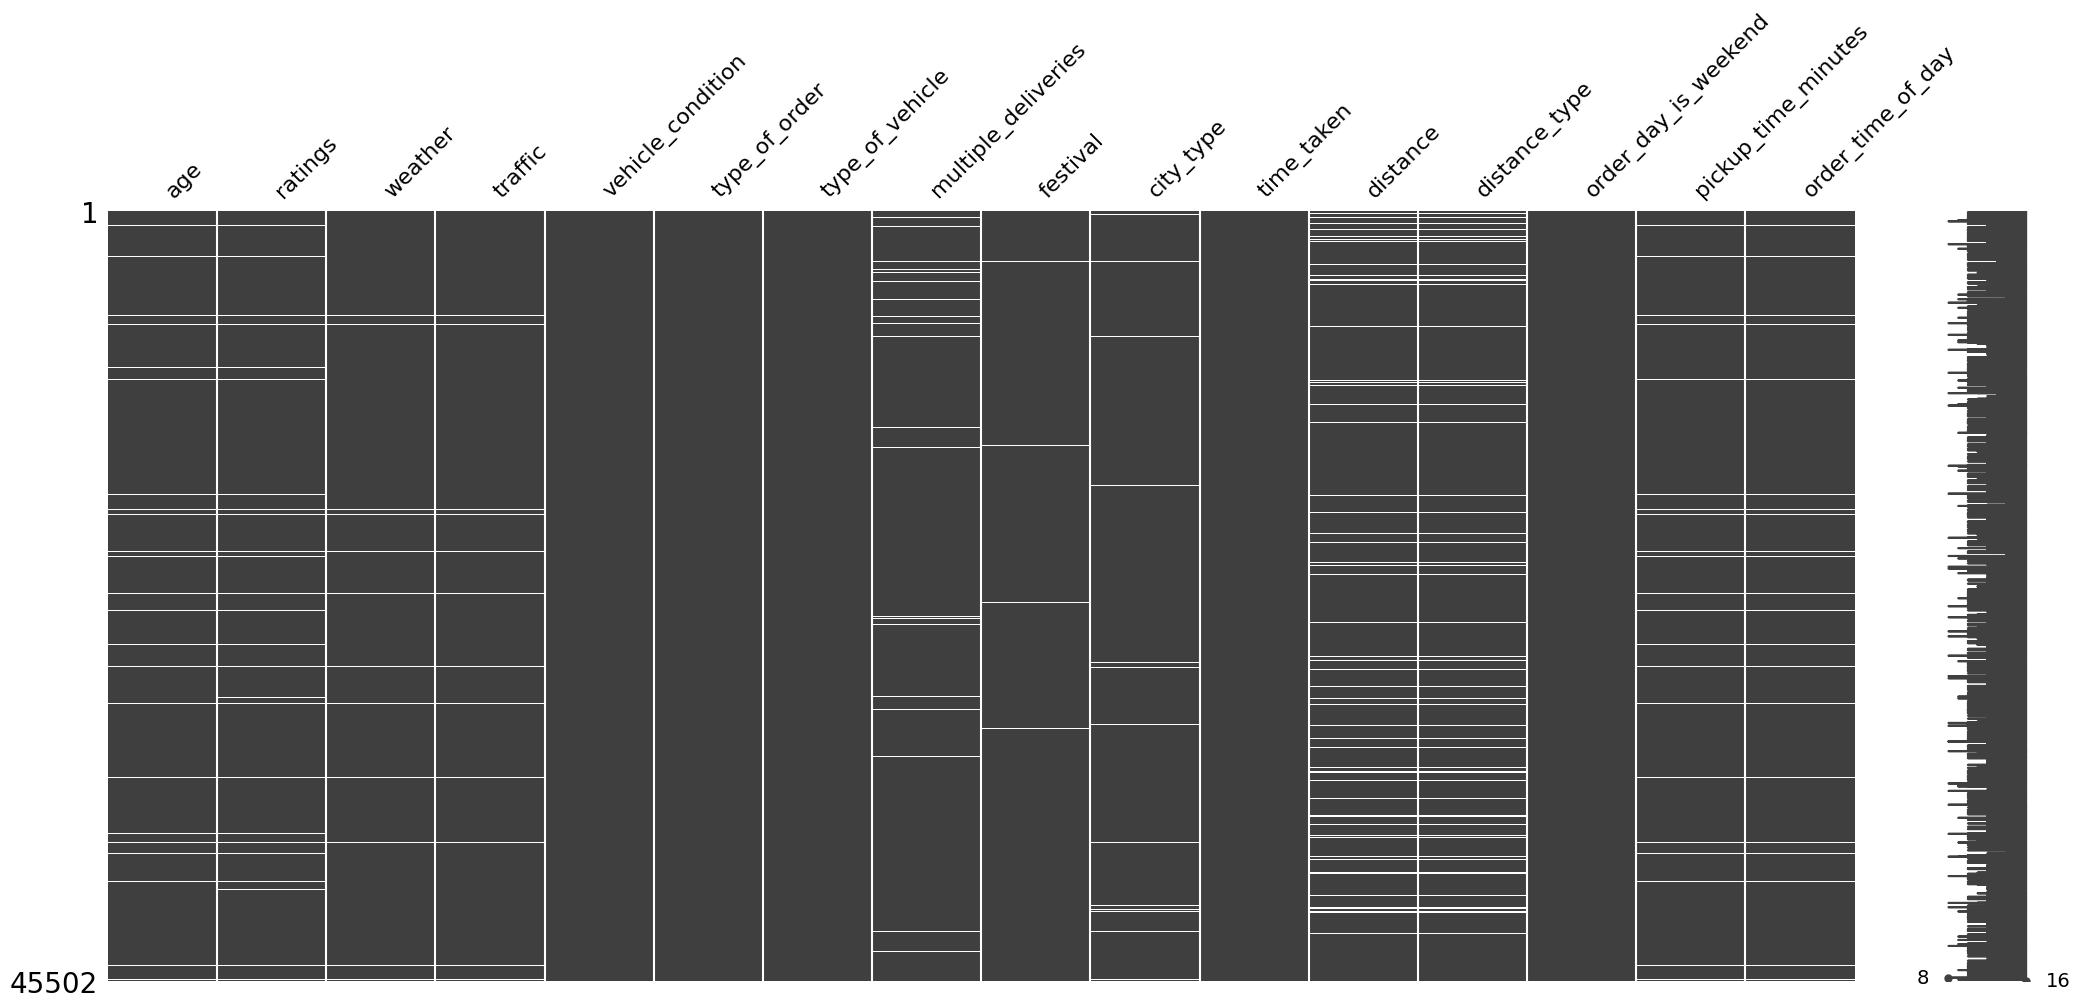

In [16]:
msno.matrix(df);

In [17]:
missing_cols = df.columns[df.isnull().any()]
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'distance', 'distance_type',
       'pickup_time_minutes', 'order_time_of_day'],
      dtype='object')

## Dropping missing values

In [18]:
temp_df = df.copy().dropna()
temp_df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,6.210138,medium,1,15.0,afternoon


## Input-output split

In [19]:
X = temp_df.drop(columns=['time_taken'])
y = temp_df['time_taken']

In [20]:
X.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,6.210138,medium,1,15.0,afternoon


In [21]:
y.head()

,time_taken
0,24
1,33
2,26
3,21
4,30


## Train-test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")

X_train.shape = (30451, 15)
X_test.shape = (7613, 15)


In [24]:
X_train.isna().sum().sum()

0

## Types of columns

In [25]:
X_train.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'distance', 'distance_type', 'order_day_is_weekend',
       'pickup_time_minutes', 'order_time_of_day'],
      dtype='object')

In [26]:
num_cols = ['age', 'ratings', 'pickup_time_minutes', 'distance']

nominal_cat_cols = [
    'weather',
    'type_of_order',
    'type_of_vehicle',
    'festival',
    'city_type',
    'order_day_is_weekend',
    'order_time_of_day',
]

ordinal_cat_cols = ['traffic', 'distance_type']

We did not consider the columns `multiple_deliveries` and `vehicle_condition` as these both are already encoded appropriately.

In [27]:
len(X_train.columns)

15

In [28]:
len(num_cols + nominal_cat_cols + ordinal_cat_cols)

13

In [29]:
for col in ordinal_cat_cols:
    print(f"{col}: {X_train[col].unique()}")

traffic: ['jam' 'low' 'medium' 'high']
distance_type: ['short', 'very_long', 'long', 'medium']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


## Creating order for ordinal categorical columns

In [30]:
traffic_order = ['low', 'medium', 'high', 'jam']
distance_type_order = ['short', 'medium', 'long', 'very_long']

## Building a preprocessor

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler(), num_cols),
        ("nominal_encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),
        ("ordinal_encoder", OrdinalEncoder(categories=[traffic_order, distance_type_order]), ordinal_cat_cols)
    ],
    remainder="passthrough",
    n_jobs=-1,
    force_int_remainder_cols=False,
    verbose_feature_names_out=False,
)

preprocessor.set_output(transform='pandas')

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scaler', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type',
                                  'order_day_is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']]),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

## Transformer for the target

In [32]:
pt = PowerTransformer(method="yeo-johnson")

y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))

## Preprocessing pipeline

In [33]:
preprocessing_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

preprocessing_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time_minutes',
                                                   'distance']),
                                                 ('nominal_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'order_day_is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']]),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

## Transforming the input

In [34]:
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

In [35]:
X_train_transformed.head()

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_urban,order_day_is_weekend_1,order_time_of_day_afternoon,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
24986,0.052632,0.80,0.5,0.163629,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1,0.0
9452,0.526316,0.96,1.0,0.157036,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,2,1.0
18442,0.631579,1.00,0.0,0.160160,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,2,2.0
15294,0.789474,0.96,0.5,0.003145,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0.0
44012,0.157895,0.88,0.5,0.084651,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0


## Hyperparameter tuning of LGBM

In [37]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 200),
            "max_depth": trial.suggest_int("max_depth", 1, 40),
            "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.8),
            "subsample": trial.suggest_float("subsample", 0.5, 1),
            "min_child_weight": trial.suggest_int("min_child_weight", 5, 20),
            "min_split_gain": trial.suggest_float("min_split_gain", 0, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model params
        mlflow.log_params(params)

        lgbm_reg = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=lgbm_reg, transformer=pt)

        # training the model
        model.fit(X_train_transformed, y_train)

        # predictions
        y_pred_train = model.predict(X_train_transformed)
        y_pred_test = model.predict(X_test_transformed)

        # cross validation
        cv_score = cross_val_score(
            model,
            X_train_transformed,
            y_train,
            cv=5,
            scoring="neg_mean_absolute_error",
            n_jobs=-1,
        )

        # mean cv score
        mean_cv_score = -(cv_score.mean())

        # log mean cv score
        mlflow.log_metric("mean_cv_score", mean_cv_score)

        return mean_cv_score

In [38]:
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # optimize the objective function
    study.optimize(objective, n_trials=30, n_jobs=-1, show_progress_bar=True)

    # log the best params
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score", study.best_value)

    # train the model on best params
    best_lgbm = LGBMRegressor(**study.best_params)
    best_lgbm.fit(X_train_transformed, y_train_transformed.values.ravel())

    # predictions
    y_pred_train = best_lgbm.predict(X_train_transformed)
    y_pred_test = best_lgbm.predict(X_test_transformed)

    y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))
    y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))

    # cross validation
    model = TransformedTargetRegressor(regressor=best_lgbm, transformer=pt)

    cv_scores = cross_val_score(
        model,
        X_train_transformed,
        y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1,
    )

    # logging metrics
    mlflow.log_metric("training_mae", mean_absolute_error(y_train,y_pred_train))
    mlflow.log_metric("test_mae", mean_absolute_error(y_test,y_pred_test))
    mlflow.log_metric("training_r2", r2_score(y_train,y_pred_train))
    mlflow.log_metric("test_r2", r2_score(y_test,y_pred_test))
    mlflow.log_metric("cross_val", -(cv_scores.mean()))

    # log the best model
    mlflow.sklearn.log_model(best_lgbm, artifact_path="model")

[I 2025-01-12 16:52:55,790] A new study created in memory with name: no-name-56eaaa7b-a8eb-443d-81ed-3bf1c8ba1a05


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run angry-quail-626 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/0dde5ddd628640f0990233eee75ea567
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:11,340] Trial 1 finished with value: 3.4983135051479577 and parameters: {'n_estimators': 161, 'max_depth': 23, 'learning_rate': 0.44310118882702076, 'subsample': 0.791016377762067, 'min_child_weight': 6, 'min_split_gain': 2.2040823370575935, 'reg_lambda': 99.22361670000988}. Best is trial 1 with value: 3.4983135051479577.
🏃 View run hilarious-eel-455 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/a741997ac9454031bf95b3f4cbc0e003
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:11,720] Trial 0 finished with value: 3.6611595171050175 and parameters: {'n_estimators': 176

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run serious-eel-149 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/9ab9545bbf0c4f8881ca50b18e4f85a5
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:15,665] Trial 2 finished with value: 3.746810570087768 and parameters: {'n_estimators': 49, 'max_depth': 29, 'learning_rate': 0.5381519043379167, 'subsample': 0.6891622013645988, 'min_child_weight': 17, 'min_split_gain': 6.571630262924998, 'reg_lambda': 51.4889235088707}. Best is trial 1 with value: 3.4983135051479577.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run righteous-smelt-948 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/ac351c9c586b46c5a82564f8e910f667
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:19,672] Trial 3 finished with value: 3.6943753163137885 and parameters: {'n_estimators': 93, 'max_depth': 39, 'learning_rate': 0.3322912588553167, 'subsample': 0.5535517281150171, 'min_child_weight': 16, 'min_split_gain': 9.398593749403325, 'reg_lambda': 24.54724264800069}. Best is trial 1 with value: 3.4983135051479577.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run enthused-dog-240 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/91d3c8ba393a4a71bc3a22a4d959520a
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:34,538] Trial 4 finished with value: 3.508527250621443 and parameters: {'n_estimators': 56, 'max_depth': 11, 'learning_rate': 0.22587459675723442, 'subsample': 0.6662920685154019, 'min_child_weight': 19, 'min_split_gain': 2.572448435275506, 'reg_lambda': 44.379223928527686}. Best is trial 1 with value: 3.4983135051479577.
🏃 View run magnificent-koi-68 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/e845ffbca1a946c0a89df124f222478d
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:34,704] Trial 5 finished with value: 3.659534824052409 and parameters: {'n_estimators': 13

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run unequaled-lamb-32 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/d531e49476e5459cbb5d2bddec1c0fee
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:39,088] Trial 6 finished with value: 3.6972864248668613 and parameters: {'n_estimators': 11, 'max_depth': 7, 'learning_rate': 0.4152114635615418, 'subsample': 0.7376304255642104, 'min_child_weight': 5, 'min_split_gain': 7.432768238859774, 'reg_lambda': 73.21600703890716}. Best is trial 1 with value: 3.4983135051479577.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run masked-pig-765 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/e781888a54114b4d901a4d1b0d358670
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:45,027] Trial 8 finished with value: 3.3533991237097114 and parameters: {'n_estimators': 27, 'max_depth': 37, 'learning_rate': 0.48948158656042073, 'subsample': 0.8242268588648145, 'min_child_weight': 10, 'min_split_gain': 0.8879100594702283, 'reg_lambda': 6.737200347206185}. Best is trial 8 with value: 3.3533991237097114.
🏃 View run trusting-steed-215 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/b9de15fec8e849ed8065134cc3f04eec
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:45,376] Trial 7 finished with value: 3.40653984427135 and parameters: {'n_estimators': 143,

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run victorious-fish-945 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/51123f948aa44d8088284390993b245e
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:53:58,844] Trial 9 finished with value: 3.6160824797930813 and parameters: {'n_estimators': 153, 'max_depth': 20, 'learning_rate': 0.12006946422096046, 'subsample': 0.9996357573579244, 'min_child_weight': 6, 'min_split_gain': 4.194576635032881, 'reg_lambda': 60.09293326130457}. Best is trial 8 with value: 3.3533991237097114.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run unruly-mole-274 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/6112f61591974225b513073770d57fab
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:07,406] Trial 11 finished with value: 4.376297844111759 and parameters: {'n_estimators': 16, 'max_depth': 1, 'learning_rate': 0.7511916583311178, 'subsample': 0.8563335791589443, 'min_child_weight': 12, 'min_split_gain': 0.1021699903584129, 'reg_lambda': 1.5086629764993864}. Best is trial 8 with value: 3.3533991237097114.
🏃 View run bemused-lark-873 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/acb6f377062741c3afc3d6c6d5dd9ff8
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:07,761] Trial 10 finished with value: 3.5705855201840064 and parameters: {'n_estimators': 96,

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run melodic-mare-514 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/879d6953151e45418c71d845588bb4c8
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:17,413] Trial 12 finished with value: 3.436555711234812 and parameters: {'n_estimators': 112, 'max_depth': 33, 'learning_rate': 0.5970569852451265, 'subsample': 0.8558646973222102, 'min_child_weight': 10, 'min_split_gain': 0.9299254817917776, 'reg_lambda': 21.65351297387184}. Best is trial 8 with value: 3.3533991237097114.
🏃 View run respected-wolf-585 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/7c417262cb7248b7be41a12e5fcd8481
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:17,577] Trial 13 finished with value: 3.283345126606119 and parameters: {'n_estimators': 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run melodic-carp-0 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/7ca98840201b45b587915d9ccf827928
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:23,448] Trial 14 finished with value: 3.5230278391094663 and parameters: {'n_estimators': 60, 'max_depth': 40, 'learning_rate': 0.5883142538551573, 'subsample': 0.622113502211828, 'min_child_weight': 13, 'min_split_gain': 1.4694628707040347, 'reg_lambda': 27.39370031416916}. Best is trial 13 with value: 3.283345126606119.
🏃 View run peaceful-cod-476 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/fc145bfc2cc846679aa48b5af031f85d
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:23,603] Trial 15 finished with value: 3.6036271751379387 and parameters: {'n_estimators': 68, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run abundant-auk-795 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/2d690e56a79a419493debbd17f5e9eba
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:38,323] Trial 16 finished with value: 3.6259199170017262 and parameters: {'n_estimators': 193, 'max_depth': 22, 'learning_rate': 0.7025265650320797, 'subsample': 0.9233234642653089, 'min_child_weight': 13, 'min_split_gain': 3.102191817944685, 'reg_lambda': 13.1302166643044}. Best is trial 13 with value: 3.283345126606119.
🏃 View run fun-crow-432 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/26dee26be7264e3f9428f17de0bc9f28
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:38,933] Trial 17 finished with value: 3.2883439688491714 and parameters: {'n_estimators': 122, '

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run sincere-kite-496 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/b7597ac544824166ab60a3912a31a6cc
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:53,886] Trial 19 finished with value: 3.790578021890943 and parameters: {'n_estimators': 116, 'max_depth': 27, 'learning_rate': 0.7934972273444898, 'subsample': 0.7753404231897436, 'min_child_weight': 15, 'min_split_gain': 5.01903972199366, 'reg_lambda': 33.966142646743165}. Best is trial 13 with value: 3.283345126606119.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run useful-zebra-244 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/563dbff9a3664d129e96f029e2c962b8
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:54:57,238] Trial 18 finished with value: 3.123660576357113 and parameters: {'n_estimators': 126, 'max_depth': 28, 'learning_rate': 0.2946865337767194, 'subsample': 0.7920223399110035, 'min_child_weight': 9, 'min_split_gain': 0.013257122215308698, 'reg_lambda': 31.754833031163244}. Best is trial 18 with value: 3.123660576357113.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run colorful-bug-643 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/868c2676fe354218994cee6564440262
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:55:01,209] Trial 20 finished with value: 3.7425449935317827 and parameters: {'n_estimators': 130, 'max_depth': 18, 'learning_rate': 0.6648398549961093, 'subsample': 0.7402525106430188, 'min_child_weight': 15, 'min_split_gain': 5.116796286860711, 'reg_lambda': 13.370800699282144}. Best is trial 18 with value: 3.123660576357113.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run charming-whale-308 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/668c7871796a41499e42cc53849201c3
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:55:17,595] Trial 21 finished with value: 3.59934794397119 and parameters: {'n_estimators': 87, 'max_depth': 16, 'learning_rate': 0.2558449281874395, 'subsample': 0.7268022870872722, 'min_child_weight': 8, 'min_split_gain': 4.723222499690798, 'reg_lambda': 61.13336239746972}. Best is trial 18 with value: 3.123660576357113.
🏃 View run unleashed-kit-885 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/a4b8fe4d3b694b98a14d78808c20fa80
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:55:17,869] Trial 22 finished with value: 3.3062362781783974 and parameters: {'n_estimators': 12

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run brawny-penguin-288 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/723314327c684c34bbd450bc3e2fe532
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:55:31,479] Trial 23 finished with value: 3.139105904459972 and parameters: {'n_estimators': 125, 'max_depth': 25, 'learning_rate': 0.30804069740137985, 'subsample': 0.8164025076420849, 'min_child_weight': 11, 'min_split_gain': 0.053819786738314335, 'reg_lambda': 33.070298246218805}. Best is trial 18 with value: 3.123660576357113.
🏃 View run illustrious-dove-423 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/ef4706738f8047be9e4247bc8fbcfcb8
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:55:31,742] Trial 24 finished with value: 3.2300493918125155 and parameters: {'n_esti

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run mercurial-fox-836 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/c73c4d6de4ac475faf18bf6e4dbc9f5e
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:55:46,460] Trial 25 finished with value: 3.4968828551470295 and parameters: {'n_estimators': 169, 'max_depth': 31, 'learning_rate': 0.3642631793094878, 'subsample': 0.879576797986048, 'min_child_weight': 11, 'min_split_gain': 1.7966894575226182, 'reg_lambda': 34.826643230912055}. Best is trial 18 with value: 3.123660576357113.
🏃 View run omniscient-stork-573 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/bb7c201c09634d78afa705d6b95a5f38
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:55:46,780] Trial 26 finished with value: 3.452167853082399 and parameters: {'n_estimator

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run calm-robin-743 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/78e0689b52904ba59d3e77a934ef067e
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
🏃 View run adaptable-chimp-824 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/06c1e81399064f32975f472d0ab26630
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:56:02,118] Trial 27 finished with value: 3.406545042028867 and parameters: {'n_estimators': 186, 'max_depth': 25, 'learning_rate': 0.21266215092787366, 'subsample': 0.9023177465300499, 'min_child_weight': 12, 'min_split_gain': 1.3483077799618053, 'reg_lambda': 15.275333006997293}. Best is trial 18 with value: 3.123660576357113.
[I 2025-01-12 16:56:02,159] Trial 28 finished with value: 3.417686388131455 and parameters: {'n_estimators':

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags

🏃 View run upbeat-kit-545 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/44b4b4c11a264a79a98509db5045761f
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8
[I 2025-01-12 16:56:07,315] Trial 29 finished with value: 3.7363667030150003 and parameters: {'n_estimators': 147, 'max_depth': 37, 'learning_rate': 0.4004576077520223, 'subsample': 0.506974827383828, 'min_child_weight': 8, 'min_split_gain': 9.30158458713272, 'reg_lambda': 16.559044180877947}. Best is trial 18 with value: 3.123660576357113.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training fr

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
2025/01/12 16:56:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run best_model at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8/runs/1233b9fe9d2c45dcb6aaaf5f921311e2
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/8


In [39]:
study.best_params

{'n_estimators': 126,
 'max_depth': 28,
 'learning_rate': 0.2946865337767194,
 'subsample': 0.7920223399110035,
 'min_child_weight': 9,
 'min_split_gain': 0.013257122215308698,
 'reg_lambda': 31.754833031163244}

In [40]:
study.best_value

3.123660576357113

In [41]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

In [42]:
# plot hyperparameter importance plot

optuna.visualization.plot_param_importances(study)

In [43]:
# slice plot

optuna.visualization.plot_slice(study)